## Action Recognition using Visual Attention

This script can be used to visualize examples similar to the ones we have presented in the paper

In [1]:
import theano
from theano import tensor
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

Using gpu device 0: Tesla K40c (CNMeM is disabled, cuDNN 5103)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
import cPickle as pkl
import numpy
import scipy

import cv2
import skimage
import skimage.transform
import skimage.io
from PIL import Image

In [3]:
import sys
sys.path.append('../')

from util.data_handler import DataHandler
from util.data_handler import TrainProto
from util.data_handler import TestTrainProto
from util.data_handler import TestValidProto
from util.data_handler import TestTestProto

import src.actrec

In [4]:
def overlay(bg,fg):
    """
    Overlay attention over the video frame
    """
    src_rgb = fg[..., :3].astype(numpy.float32) / 255.
    src_alpha = fg[..., 3].astype(numpy.float32) / 255.
    dst_rgb = bg[..., :3].astype(numpy.float32) / 255.
    dst_alpha = bg[..., 3].astype(numpy.float32) / 255.

    out_alpha = src_alpha + dst_alpha * (1. - src_alpha)
    out_rgb = (src_rgb * src_alpha[..., None] + dst_rgb * dst_alpha[..., None] * (1. - src_alpha[..., None])) / out_alpha[..., None]

    out = numpy.zeros_like(bg)
    out[..., :3] = out_rgb * 255
    out[..., 3] = out_alpha * 255

    return out

### set variables here

In [16]:
model ='/home/pmorerio/code/Intention-from-Motion/old/smooth_30_class_1/2016-10-29 07:12:44_12/model.npz'
# PROBLEM here in videopath: subfolders
data_dir='/data/datasets/IIT_IFM_AUT/smooth_30_crossval_class1/'
videopath = '/data/datasets/IIT_IFM_AUT/2D/'
dataset ='IfM_12'
tbidx = 5 # number of video file in xxx_filename

with open('%s.pkl'%model, 'rb') as f:
    options = pkl.load(f)

batch_size = 1

flen =[]
for line in open(data_dir+'12_test_framenum.txt'): # test
    flen.append(line.strip())
maxlen = int(flen[tbidx]) # to get the alphas for the whole tbidx-th video
#maxlen = options['maxlen']
print 'Video Length:', maxlen



# try out different fps for visualization
# NO! DO NOT!
fps = options['fps']
# fps = 10   # to see further on along the sequence
skip = int(100/fps)

Video Length: 74


In [17]:
params  = src.actrec.init_params(options)
params  = src.actrec.load_params(model, params)
tparams = src.actrec.init_tparams(params)

trng, use_noise, inps, alphas, cost, opt_outs, preds = src.actrec.build_model(tparams, options)
f_alpha = theano.function(inps,alphas,name='f_alpha',on_unused_input='ignore')
f_preds = theano.function(inps,preds,profile=False,on_unused_input='ignore')

mask = numpy.ones((maxlen, batch_size)).astype('float32')

In [18]:
print '-----'
print 'Skip set at', skip
print 'Booting up the data handler'

 # or TestTrainProto or TestValidProto (remember to change file in [33])
data_pb = TestTestProto(batch_size,maxlen,maxlen,dataset,data_dir, fps)
dh = DataHandler(data_pb)
dataset_size = dh.GetDatasetSize()
num_batches = dataset_size / batch_size



print 'Data handler ready'
print '-----'

-----
Skip set at 1
Booting up the data handler
Dataset size 11
Batch shape (74, 1, 50176)
Data handler ready
-----


In [19]:
x, y, fname = dh.GetSingleExample(data_pb,tbidx)
alpha = f_alpha(x,mask,y)
print alpha.shape
print videopath+fname
vidcap = cv2.VideoCapture(videopath+fname)
space = 255.0*numpy.ones((224*2,20,4))
space[:,:,0:3] = 255.0*numpy.ones((224*2,20,3))

imgf = numpy.array([]).reshape(2*224,0,4)
skip = 10
for ii in range(0,alpha.shape[0],skip):
    # read frame
    success, image = vidcap.read()
    if success:
        oldimage = image
    if not success:
        image = oldimage

    # crop as in matlab feature extraction
    image = image[1:720, 1:1130]
    
    # add an Alpha layer to the RGB image
    image = cv2.resize(image, (224, 224))
    img = numpy.array(image)
    alphalayer = numpy.ones((224,224,1))*255
    img = numpy.dstack((img,alphalayer)) #rgba

    # create the attention map and add an Alpha layer to the RGB image
    alpha_img = skimage.transform.pyramid_expand(alpha[ii,0,:].reshape(7,7), upscale=32, sigma=20)
    alpha_img = alpha_img*255.0/numpy.max(alpha_img)
    alpha_img = skimage.color.gray2rgb(alpha_img)
    alpha_img = numpy.dstack((alpha_img,0.8*alphalayer)) #rgba

    old_img = img
    img = overlay(img,alpha_img)

    img  = numpy.concatenate((old_img,img),axis=0)
    imgf = numpy.concatenate((imgf,img),axis=1)
    imgf = numpy.concatenate((imgf,space),axis=1)
    
    print 'Frame', ii
    # skip frames according to variable skip
    for sk in xrange(skip-1):
        #print ii+sk+1
        suc, im = vidcap.read()
        if not suc:
            break

(74, 1, 49)
/data/datasets/IIT_IFM_AUT/2D/1/S012_030.mp4
Frame 0
Frame 10
Frame 20
Frame 30
Frame 40
Frame 50
Frame 60
Frame 70


**`imgf`** is the (h,w,4) image array containing **`maxlen/skip+1`** frames with the model's attention

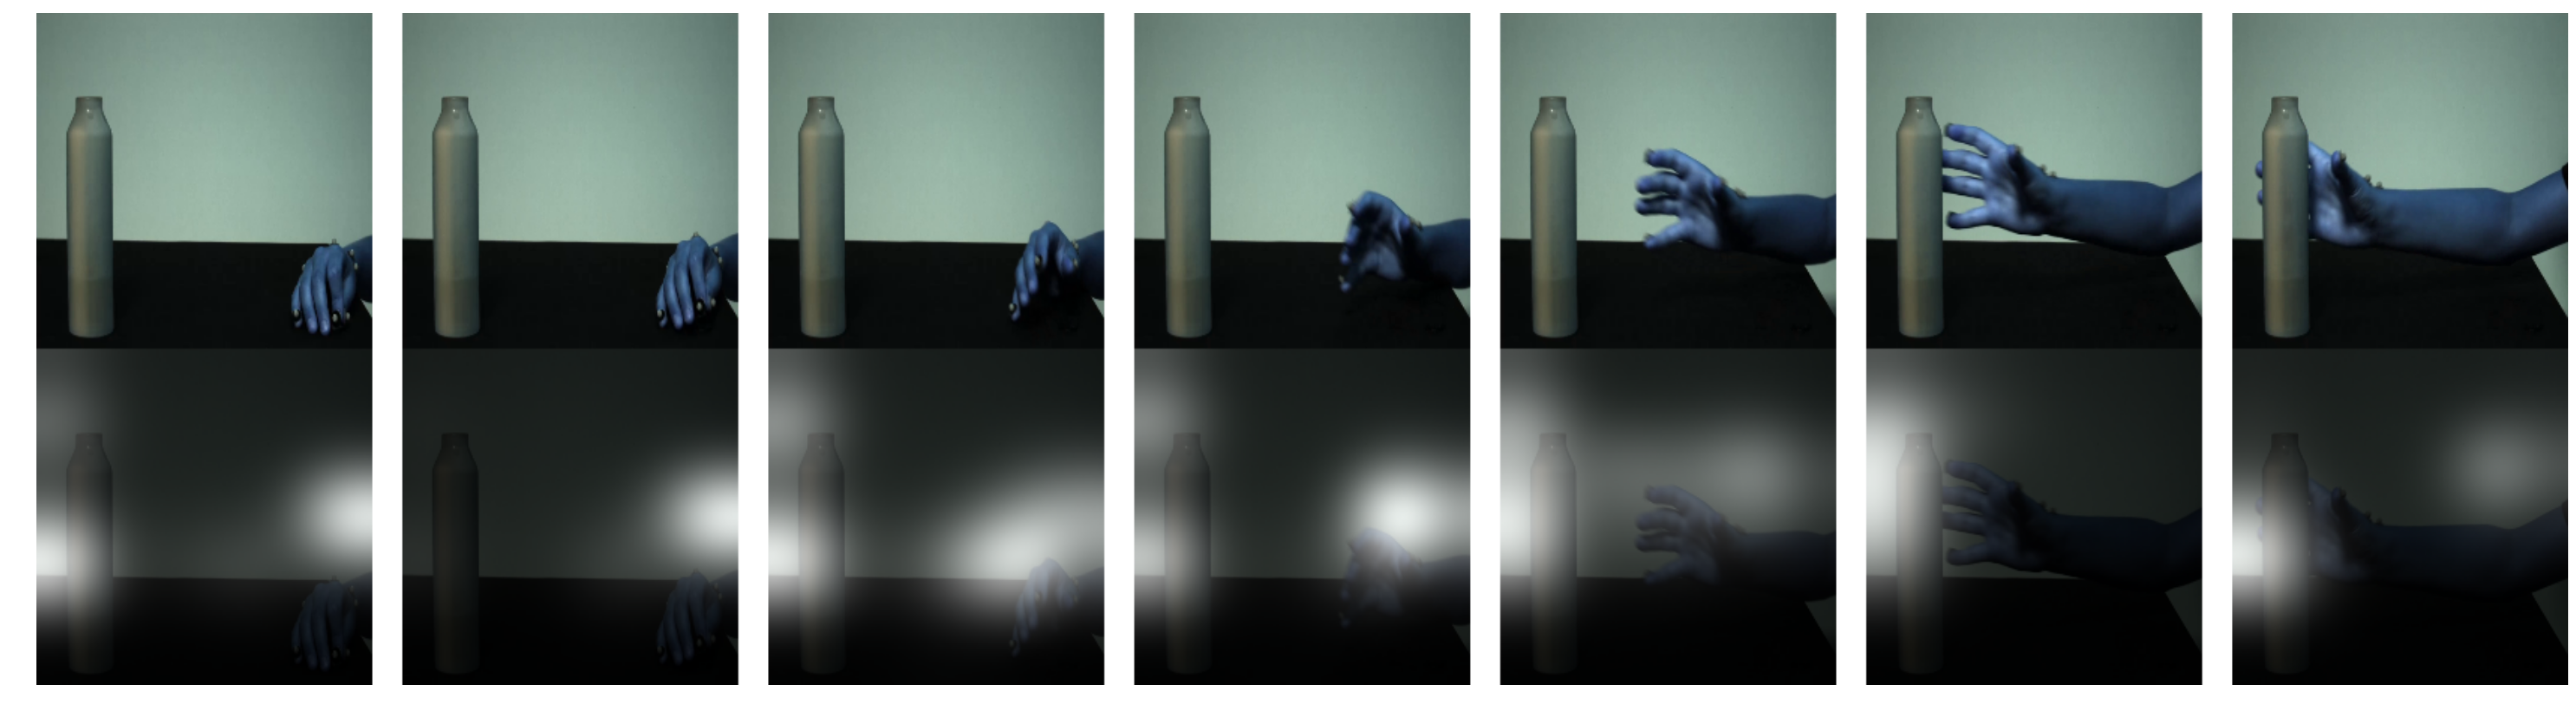

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(40,10))
plt.axis('off')
dispCount = 7                         # displays the
width = 224 + (20+224)*(dispCount-1)  # first dispCount frames
ax = plt.imshow(imgf[:,:width,:]/255)